### Simple Toy Mecha Implementation of GotMilk ###

#### Paul Cohen, Oct 3, 2022 ####

Pearl and Hopkins develop a mapping between situation calculus and Pearl's do-calculus.  We think it might be a good basis for Decision Motifs because it handles things that other probabilistic models don't, particular an ordinal notion of time and some subtleties in common causal stories that are otherwise hard to express. Their central example is a "shooting problem."  Rather than a discussing the arcane details of people executing other people, I propose the following, more benign but structurally identical problem:

Dad and Kid are shopping for groceries in different markets.  Mom texts that the family needs milk. If Dad and Kid are texted to buy milk, then they buy milk or they forget.  Sometimes Dad or Kid will buy milk even if they are not texted by Mom.  After buying groceries, Dad and Kid return home.  The family then has milk or it doesn't.

This problem is easy to implement in the Mecha ABM framework, but Mecha hides a lot of mechanism that needs to be exposed when configuring simulators to answer questions.  For expedience, I have borrowed many of the design principles of Mecha in the following "Toy Mecha," which exposes pretty much everything. 

The key thing to know about Mecha and Toy Mecha is that they run many experiments in parallel by making each experiment a vector of random variables that are updated by rules.  A batch of experiments is just a 2D Numpy array (or in Toy Mecha, a Pandas dataframe). 

In [2]:
import os
os.chdir("../..")

import numpy as np
from numpy.random import default_rng
rng = default_rng() # stuff for random sampling

import pandas as pd
import matplotlib.pyplot as plt


class GotMilk ():
    ''' This class is absurdly specific to the GotMilk problem, but it does much of what Mecha
    does more generally when setting up a simulation'''
    
    def __init__(self,n, pDadSawText, pKidSawText, pNeedMilk, 
                 pDadAutoBuy, pKidAutoBuy):
        
        self.n = n # the number of experiments or rows in the dataframe
        self.pDadSawText = pDadSawText
        self.pKidSawText = pKidSawText
        self.pNeedMilk = pNeedMilk
        self.pDadAutoBuy = pDadAutoBuy
        self.pKidAutoBuy = pKidAutoBuy
        self.init_world()
        
   
    def init_world (self): 
        ''' Make dataframes for simulation state and results.  Initialize the probabilities 
        of texting and buying milk at each time step'''

        self.df = pd.DataFrame(
            np.zeros((self.n,7)).astype(bool),
            columns = ['needMilk', 'MomTexts', 'dadSawText', 'DadBuysMilk', 
                       'kidSawText', 'KidBuysMilk','gotMilk']
        )
        
        # These are "initial conditions" but in Mecha proper they might be re-evaluated
        # at any point in a simulation
        self.df.dadSawText = rng.random(self.n) < self.pDadSawText
        self.df.kidSawText = rng.random(self.n) < self.pKidSawText
        self.df.needMilk = rng.random(self.n) < self.pNeedMilk
        
        
        
    
gm = GotMilk(
    n = 1000,
    pDadSawText = 1,  # probability that Dad wants milk
    pKidSawText = 1,  # probability that Dad wants milk
    pNeedMilk = 0.5,       # probability that the house gets milk not from Dad or Kid (perhaps from a neighbor?)
    pDadAutoBuy = 0.25,    # probability that Dad will get milk even if he's not texted
    pKidAutoBuy = 0     # probability that Kid will get milk even if she's not texted
)


print(np.sum(gm.df.MomTexts))
gm.df.describe()

0


,needMilk,MomTexts,dadSawText,DadBuysMilk,kidSawText,KidBuysMilk,gotMilk
count,1000,1000,1000,1000,1000,1000,1000
unique,2,1,1,1,1,1,1
top,False,False,True,False,True,False,False
freq,539,1000,1000,1000,1000,1000,1000


Now we'll define a very lightweight version of Mecha's simulator class.  It will register rules, maintain a list of actions, and collect and display results.

In [3]:
class Sim ():
    def __init__(self, world, k = 25, to_record= ['MomTexts','DadBuysMilk','KidBuysMilk', 'gotMilk']):
        self.world = world
        self.df = world.df
        self.k = k        # number of simulation iterations
        self.to_record = to_record # the attributes to record as the sim runs
        self.actions = [] # a queue of actions specified by rules
        self.rules = []   # a list of rules created by `register_rule`
        self.results = pd.DataFrame(columns=self.to_record) # where results are stored as sim runs
    
    def with_prob (self,p):
        return rng.random(self.world.n) < p
    
    def prob_of (self,col):
        return np.sum(col)/self.world.n
        
    def reset (self,reset_rules_actions=False):
        self.world.init_world()
        self.df = self.world.df
        self.results = pd.DataFrame(columns=self.to_record)
        if reset_rules_actions:
            self.rules = []
            self.actions=[]
    
    def register_rule (self,attribute,fun):
        self.rules.append(lambda: self.actions.append((attribute,fun)))
        
    def execute_rules (self):
        for rule in self.rules: rule()
                    
    def execute_actions (self):
        for action in self.actions:
            self.df[action[0]]=action[1](self)
        self.actions=[]
        
    def run (self):
        for i in range(self.k):
            self.execute_rules()
            self.execute_actions()
            self.record_data()
        
    def record_data (self):
        self.results.loc[len(self.results)] = [self.prob_of(self.df[col]) for col in self.to_record]
        
    def plot_results (self):
        for col in self.to_record:
            plt.plot(self.results[col], label=col)
        plt.legend()
        plt.show()


sim = Sim(world=gm)  
sim.reset() # resets the sim's world
print(np.sum(sim.df.MomTexts))

0


Now we can register a rule with the sim. Whereas Mecha allows rules that make many probabilistic changes to multiple attributes,Toy Mecha allows rules that make only one deterministic change to a single attribute. This will suffice for the GotMilk problem.

To register a rule, we say which attribute should be changed and what its value should be when the rule executes.  (Note that execution must be lazy, meaning that the rule binds arguments at the moment it is executed. This is why Toy Mecha rules are lambda expressions.) The following rule affects the `MomTexts` attribute of the simulated world.  It says that the value of `MomTexts` is:

1) True if `MomTexts` is (already) True

2) True if `needMilk` is True.  



In [4]:
sim.register_rule(
    'MomTexts', 
    lambda self: (self.df.MomTexts) | (self.df.needMilk)
)
                                   
sim.rules[0]

<function __main__.Sim.register_rule.<locals>.<lambda>()>

When a rule executes, it doesn't change the world immediately.  This is because we want all rules to decide how to act in a given state of the world before any of them acts, lest we get strange interactions between rule actions in a single time step.  So here's what happens in a single time step:

1) Each rule creates an action

2) After all rules have created their actions, each action is executed

Let's walk through an example:

In [4]:
#reset the sim and the world
sim.reset()

print(np.sum(sim.df.MomTexts)) # should be zero
print(sim.actions) # should be an empty list

sim.execute_rules()
print(sim.actions) # should hold action
print(np.sum(sim.df.MomTexts)) # should still be zero because the action hasn't been executed

sim.execute_actions()
print(sim.actions) # should be empty after executing the action
print(np.sum(sim.df.MomTexts)) # should be between 400 and 550 ish


0
[]
[]
0
[]
0


If you comment out the sim.reset and run the preceding block repeatedly, what do you think will happen to the number of MomTexts events?  This is actually quite a subtle point: If the `with_prob` method didn't construct a new probability disribution each time it is called, then number of MomTexts events would never change.  It's worth thinking about this for a moment because it illustrates the difference between initial conditions (e.g., the probability that Dad likes milk, which can be assessed before the sim begins) and other conditions that need to be re-evaluated during simulation, such as random events.   

Okay, now we can define all the rules we need.

In [5]:
# start fresh:
sim.reset(reset_rules_actions = True)


# MomTexts is true if Mom has already texted or with probability pMomUrgent if milk is needed 
sim.register_rule(
    'MomTexts', 
    lambda self: (self.df.MomTexts) | (self.df.needMilk)
)

# DadBuysMilk is True if he's already bought milk or if Mom texts and Dad wants milk or if Dad randomly buys milk
sim.register_rule(
    'DadBuysMilk', 
    lambda self: (self.df.DadBuysMilk) | (self.df.MomTexts) & (self.df.dadSawText) | self.with_prob(self.world.pDadAutoBuy)
)

# KidBuysMilk is True if she's already bought milk or if Mom texts and Kid wants milk or if Kid randomly buys milk
sim.register_rule(
    'KidBuysMilk', 
    lambda self: (self.df.KidBuysMilk) | (self.df.MomTexts) & (self.df.kidSawText) | self.with_prob(self.world.pKidAutoBuy)
)
# dadSawText is True if it's already true or if Mom texts
sim.register_rule(
    'dadSawText', 
    lambda self: (self.df.dadSawText) | (self.df.MomTexts)
)
# kidSawText is True if it's already true or if Mom texts

sim.register_rule(
    'kidSawText', 
    lambda self: (self.df.kidSawText) | (self.df.MomTexts)
)

# GotMilk is True if it's already true or if Dad or Kid buy milk or if milk is randomly gotten
sim.register_rule(
    'gotMilk', 
    lambda self: (self.df.gotMilk) | (self.df.DadBuysMilk) | (self.df.KidBuysMilk) 
)

Finally we can run the simulator.  We start by resetting it (because we might have run it earlier).  Don't say `sim.reset(reset_rules_actions=True)` because if you do, then you'll have to re-define the rules.

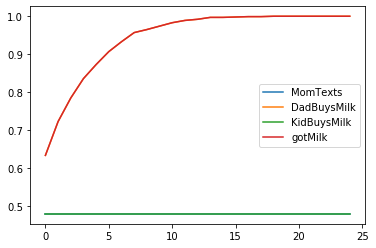

,MomTexts,DadBuysMilk,KidBuysMilk,gotMilk
0,0.48,0.634,0.48,0.634
1,0.48,0.723,0.48,0.723
2,0.48,0.785,0.48,0.785
3,0.48,0.836,0.48,0.836
4,0.48,0.873,0.48,0.873
5,0.48,0.907,0.48,0.907
6,0.48,0.933,0.48,0.933
7,0.48,0.957,0.48,0.957
8,0.48,0.965,0.48,0.965
9,0.48,0.974,0.48,0.974


In [6]:
sim.reset()
sim.run()
sim.plot_results()
sim.results

## Calculating Probabilities and Answering Questions ##

The following is work in progress.

Now we can calculate transition probabilities between states.  A state is indexed by time (the step of the simulation) and is a vector of four binary variables -- `MomTexts`,`DadBuysMilk`,`KidBuysMilk`.  For ease of human comprehension (though it slows things down), states are represented by strings; for example, '0101' represents Mom has not texted, Dad buys milk, kid doesn't buy milk, and we have milk. 

Each state has a probability which is the number of rows in our numpy array at a given time that match that state. We can then ask for the conditional probability of any given next state given a current state. 

In [7]:
# Keep this, I may need it later.  It's for state arrays rather than state strings
# def transition0 (x0,x1,time):
#     ht[time]={}
#     u0,c0 = np.unique(x0,axis=0,return_counts=True)
#     print(u0,c0)
#     for pattern0,count0 in zip(u0,c0): 
#         u1,c1 = np.unique(x1[np.all(x0==pattern0,axis=1)],axis=0,return_counts=True)
#         ht[time].update({str(pattern0):{str(pattern1):np.round(count1/count0,3) for pattern1,count1 in zip(u1,c1)}})

def state_string (x):
    '''Makes a string representation of a list'''
    return "".join([str(i) for i in x])

def transition (ht,x0,x1,time):
    ''' Builds a multilevel dict ht:  {time : {state0 : {state1:transition_prob}}} '''
    ss0 = x0.apply(state_string,axis=1) # state 0 as a string
    ss1 = x1.apply(state_string,axis=1) # state 1 as a string
    
    # All states are time-indexed because P(ss1 | ss0) at time 0 
    # generally doesn't equal P(ss1 | ss0) at another time
    ht[time]={}
    
    # count instances of unique states ss0
    u0,c0 = np.unique(ss0,return_counts=True)
    
    # for each unique state 
    for state0,count0 in zip(u0,c0): 
        # count instances of unique states ss0
        u1,c1 = np.unique(ss1[ss0==state0],return_counts=True)
        # calculate and record transition probabilities
        ht[time].update({str(state0):{str(state1):np.round(count1/count0,3) for state1,count1 in zip(u1,c1)}})    

I'll run the simulator manually for two steps, recording the states and calculating transition probabilities.  Once it works satisfactorily, `transition` could be a `Sim` method.

In [65]:
ht={}

sim.reset()
x0 = sim.df[['MomTexts','DadBuysMilk','KidBuysMilk','gotMilk']].astype(int)

sim.execute_rules()
sim.execute_actions()
x1 = sim.df[['MomTexts','DadBuysMilk','KidBuysMilk','gotMilk']].astype(int)
transition(ht,x0,x1,0)
ht

{0: {'0000': {'0000': 0.404, '0101': 0.127, '1111': 0.469}}}

Now let's step the simulator again and record transitions again:

In [67]:
sim.execute_rules()
sim.execute_actions()
x2 = sim.df[['MomTexts','DadBuysMilk','KidBuysMilk','gotMilk']].astype(int)
transition(ht,x1,x1,1)
ht

        
        
        
def q_prob (time,state0,state1):
    s = ht.get(time)
    if s:
        s0 = s.get(state0)
        if s0:
            s1 = s0.get(state1)
            if s1:
                print(f'At time {time}, P({state1}|{state0})={s1}')
            else:
                print(f'At time {time}, {state1} is not a successor to {state0}')
        else:
            print(f'At time {time}, {state0} does not exist')                 
    else:
        print(f'time {time} does not exist')
    
        

# Potential situation for GotMilk example
 
![GotMilk](GotMilk.png)

For our GotMilk example, we have an SCCM $M=(D, P)$ where $D$ is the sitcalc specification in Figure 5 (without the axiom $\lnot\texttt{gotMilk}(S_0)$), and the potential situation $P=[\texttt{MomTexts, DadBuysMilk, KidBuysMilk}]$.  

We define a **query term** as any ground action term of $D$, or any ground fluent formula of $D$, with the situation argument removed. For example, for our firing squad sitcalc specification, $\texttt{gotMilk}$ would be a query term, rather than $\texttt{gotMilk}(s)$.

A **basic causal formula** has the syntax $[\lnot a_1,\ldots,\lnot a_m, b_1,\ldots, b_n]q(U)$ where the semantics of this formula means:  "In a world where $U$ are the initial axioms at $S_0$, if $\lnot a$, yet $b$ somehow occurs, $q$ will occur when all is said and done" 
 
 Let us evaluate the formula $[\lnot\texttt{MomTexts, KidBuysMilk}]\ \texttt{gotMilk}(U)$ where $U$ is the singleton set with axiom $\texttt{needMilk}(S_0)$  (notice the correspondence with exogenous variables in the SCM framework).  
 
$$M\models [\lnot\texttt{MomTexts, KidBuysMilk}]\ \texttt{gotMilk}(U)$$

if $$\texttt{gotMilk}(NES([\lnot \texttt{MomTexts, KidBuysMilk}]\ M(U)))$$

holds. Indeed it does, since:

$$NES([\lnot \texttt{MomTexts, KidBuysMilk}]\ M(U)) = [\texttt{KidBuysMilk}]$$

Thus we conclude that if Mom does not text, and yet the Kid still (somehow) buys milk, milk will be gotten when all is said and done. We can also consider probabilistic counterfactuals. Take probabilistic SCCM $<M, P(U)>$ where $M$ is the SCCM defined above and $P(U)$ is a distribution over the two singleton sets $[\texttt{needMilk}(s_0)]$ and $[\lnot\texttt{needMilk}(s_0)]$. Evaluating:

$$Pr([\lnot\texttt{KidBuysMilk}]\ \texttt{gotMilk}) = \sum_U([\lnot\texttt{KidBuysMilk}]\ \texttt{gotMilk}(U)\cdot Pr(U))$$

we see that the probability that we get milk when the kid is *forced* not to buy milk is equivalent to the probability of $\lnot\texttt{needMilk}(S_0)$, i.e. the prior probability that we need milk.

Given a situation-calculus specification $D$, a **potential situation** $P$ is a pair $(S, F)$ where $S$ is a (not necessarily executable) situation of $D$ and $F: \{a|a\in S\}\to \{0,1\}$ is a function that maps each $a\in S$ to either $0$ or $1$.

$F$ associates either a zero or one to each action of the situation.  Thes values are flags to ignore the preconditions of a particular action (as in the example where we force Dad to buy milk, regardless of whether he receives a text from Mom). Generally when initially defining a potential situations, we want $F$ to be the trivial function that maps all actions of $S$ to 0.  We call this function $F_0(S)$.
We are now ready to define causal models in the situation calculus.

## Definition 3
Let $S = [a_1,\ldots,a_n]$ be a situation and let $A$ be a set of ground action terms. We define $S-A$ as a new situation, derived by "removing" the actions of $A$ from $S$ using the following construction:

1. Let $S-A = S_0$
2. For $i=1$ to $n$: if $a_i\not\in A$ then let $S-A\leftarrow do(a_i, S-A)$.

Intuitively $S-A$ is the situation $S$ with any mention of the actions in $A$ removed.  $a\in S$ means that an action $a$ appears in the sequence of actions $S$.


In our example, $S-A$ is $[\lnot \texttt{MomTexts}]$ the new situation is $[\texttt{KidBuysMilk, DadBuysMilk}]$

## Definition 6

A **situation calculus causal model (SCCM)** is a pair $(D,P)$ where $D$ is a situation calculus specification (with a possibly incompletely specified initial situation) and $P$ is a potential situation of $D$.

Given an SCCM $M=(D,P)$, we can fully specify the inital situation with a set $U$ of axioms that fully specify the values of the fluents and situation-independent  predicates of $D$.  We shall use $M(U)$ to denote the new SCCM $(D\cup U, P)$.

In our example, $D$ is:





|  Actions |  Fluents | Action precondition axioms | Successor-state axioms 
|---------|----------|---------------------------|--------|
|  `MomTexts` |   | $Poss(\texttt{momTexts},s) \equiv \texttt{needMilk}(s)$ | |
| `DadBuysMilk` | `dadSawText(s)` | $Poss(\texttt{DadBuysMilk},s)\equiv \texttt{MomTexts}\land\texttt{dadSawText}(s)$ | $\texttt{dadSawText}(do(a,s))\equiv \texttt{MomTexts}\lor\texttt{dadSawText}(s)$ |
|  `KidBuysMilk` |  `kidSawText(s)` | $Poss(\texttt{KidBuysMilk},s)\equiv \texttt{MomTexts}\land\texttt{kidSawText}(s)$ | $\texttt{kidSawText}(do(a,s))\equiv \texttt{momTexts}\lor\texttt{kidSawText}(s)$ |
|  | `gotMilk(s)`  |  | $\texttt{gotMilk}(do(a,s))\equiv\texttt{gotMilk}(s)\lor\texttt{DadBuysMilk}\lor\texttt{KidBuysMilk}$ |

$P$ is $[\texttt{MomTexts, DadBuysMilk, KidBuysMilk}]$ 

$U$ is $\texttt{needMilk}(s_0)$

$q$ is  $\texttt{gotMilk} = True$

$\phi$ is $[\lnot \texttt{MomTexts, KidBuysMilk}]\ q(U)$ which is $[\lnot \texttt{MomTexts, KidBuysMilk}]\ q=\left\{\texttt{gotMilk}=True\right\}\ (U=\texttt{needMilk}(s_0))$


| Objects | Actions | Situation-independent predicates | Fluents | Action precondition axioms | Successor-state axioms 
|---------|---------|-----------------------------------|----------|---------------------------|--------|
| `Mom`     | `texts(mom,milk)` | `isMom(mom)`  |  | $Poss(\texttt{texts}(mom,milk),s) \equiv \exists (milk)\texttt{need}(milk,s)\land \texttt{isMilk}(milk)$ |  |
| `Dad`   | `buys(dad,milk)` | `isShopping(dad)` | `sawText(dad,s)` | $Poss(\texttt{buys}(dad,milk),s)\equiv \texttt{texts}(mom,milk)\land\texttt{isMom}(mom)\land\texttt{isMilk}(milk)\land\texttt{sawText}(dad,s)\land\texttt{isShopping}(dad)$ | $\texttt{sawText}(dad, do(a,s))\equiv \texttt{texts}(mom,milk)\lor\texttt{sawText}(dad,s)$ |
| `Kid`   | `buys(kid,milk)` | `isShopping(kid)` | `sawText(k, s)` | $Poss(\texttt{buys}(kid,milk),s)\equiv \texttt{texts}(mom,milk)\land\texttt{isMom}(mom)\land\texttt{isMilk}(milk)\land\texttt{sawText}(dad,s)\land\texttt{isShopping}(kid)$ | $\texttt{sawText}(kid, do(a,s))\equiv \texttt{texts}(mom,milk)\lor\texttt{sawText}(kid,s)$ | 
| `Milk`  |  | `isMilk(x)` | `gotMilk(s)`  |  | $\texttt{gotMilk}(do(a,s))\equiv\texttt{gotMilk}(s)\lor\texttt{dadBuysMilk}\lor\texttt{kidBuysMilk}$ 


## Definition 7

Given a situation calculus causal model $M=(D, P=([a_1,\ldots, a_n],F))$ (with a fuly specified initial situation), the **natural executable situation** $NES(M)$ is constructed iteratively as follows:
1. Let $NES(M) = S_0$
2. For $i=1$ to $n$: if $(M\models Poss(a_i, NES(M)) or F(a_i)=1)$ then let $NES(M)=do(a_i, NES(M)))$


Essentially, we attempt to perform each action of the potential situation in order. If it ispossible to perform the action at each given step (or if the action is being forced to occur), we add it to the natural executable subsituation; if not, we omit it. Semantically, the natural executable subsituation of a causal model corresponds to the actual course of events under that model.

In [1]:
    
x0 = sim.df[['MomTexts','DadBuysMilk','KidBuysMilk','GotMilk']].astype(int)

for time in range(10):
    Signals(.5)
    Shoots1(.05)
    Shoots2(.05)
    Dies()
    
    x1 = sim.df[['Signal','Shoots1','Shoots2','dead']].astype(int)
    transition(x0,x1,time)
    # query the probability of a state of x1 given a state of x0
    q_prob(time,'1111','1111')
    x0 = x1
    

NameError: name 'sim' is not defined

In [261]:
ht

{0: {'0000': {'0000': 0.706,
   '0011': 0.029,
   '0101': 0.026,
   '0111': 0.003,
   '1111': 0.236}},
 1: {'0000': {'0000': 0.755,
   '0011': 0.04,
   '0101': 0.05,
   '0111': 0.004,
   '1111': 0.152},
  '0011': {'0011': 0.828, '1111': 0.172},
  '0101': {'0101': 0.769, '1111': 0.231},
  '0111': {'0111': 1.0},
  '1111': {'1111': 1.0}},
 2: {'0000': {'0000': 0.812, '0011': 0.049, '0101': 0.051, '1111': 0.088},
  '0011': {'0011': 0.827, '0111': 0.019, '1111': 0.154},
  '0101': {'0101': 0.855, '0111': 0.036, '1111': 0.109},
  '0111': {'0111': 1.0},
  '1111': {'1111': 1.0}},
 3: {'0000': {'0000': 0.859, '0011': 0.044, '0101': 0.046, '1111': 0.051},
  '0011': {'0011': 0.913, '0111': 0.043, '1111': 0.043},
  '0101': {'0101': 0.892, '0111': 0.081, '1111': 0.027},
  '0111': {'0111': 0.889, '1111': 0.111},
  '1111': {'1111': 1.0}},
 4: {'0000': {'0000': 0.871, '0011': 0.054, '0101': 0.043, '1111': 0.032},
  '0011': {'0011': 0.915, '0111': 0.037, '1111': 0.049},
  '0101': {'0101': 0.942, '0111':

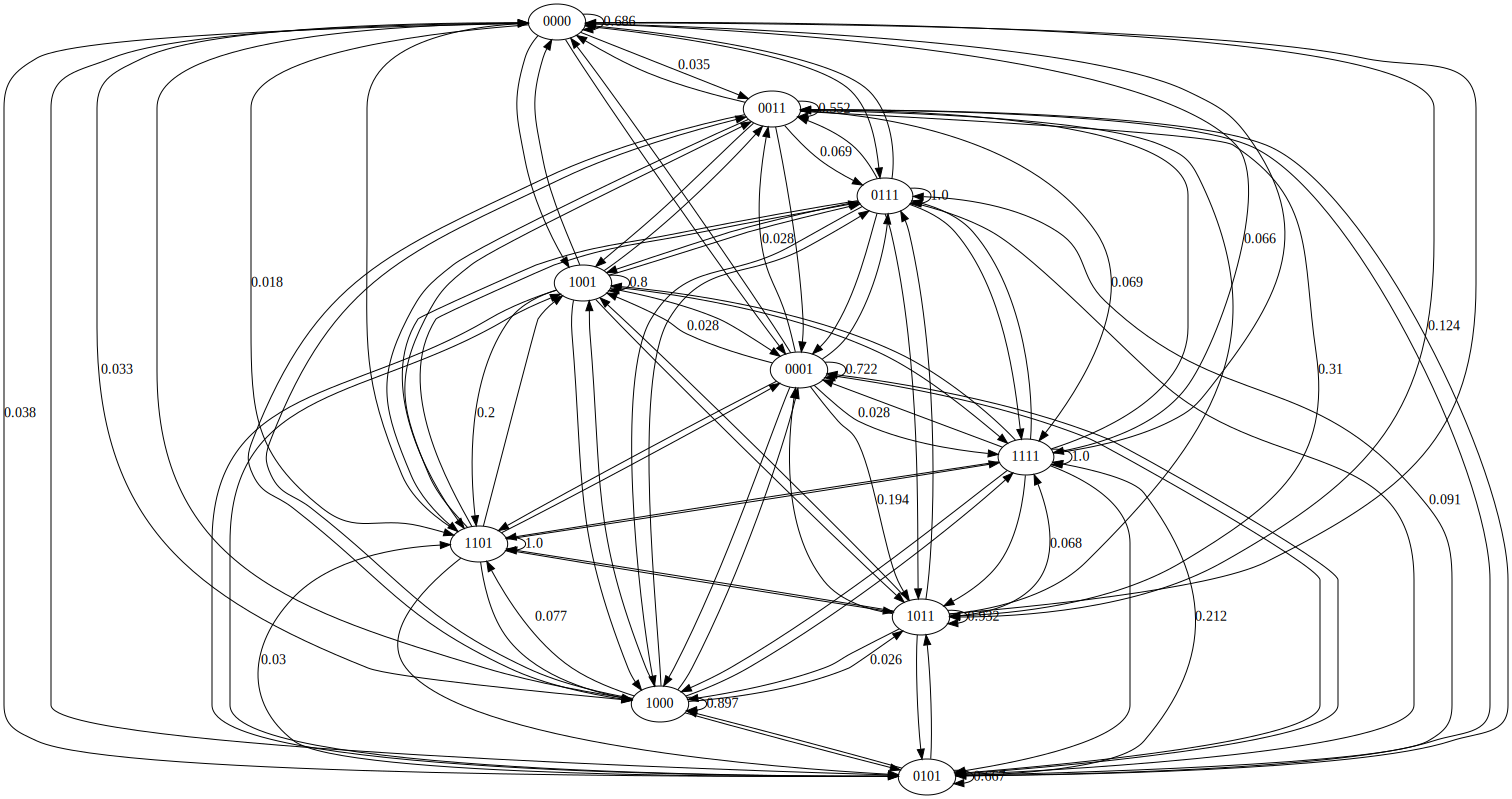

In [246]:

import graphviz as gv
G = gv.Digraph(strict=True)
x = ht[1]
states = list(set(list(x.keys())+[y for z in [list(i.keys()) for i in x.values()] for y in z]))
for n0 in list(x.keys()):
    for n1 in [y for z in [list(i.keys()) for i in x.values()] for y in z]:
        label = x.get(n0).get(n1)
        if label is not None:
            G.edge(n0,n1,label=str(label))
        else:
            G.edge(n0,n1)

G